In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import requests
import pandas as pd

# Fetch data from CoinGecko
def get_coingecko_data():
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": "usd",
        "order": "market_cap_desc",
        "per_page": 10,  # Top 10 cryptocurrencies
        "page": 1,
        "sparkline": False
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data)[["id", "symbol", "current_price", "market_cap", "total_volume", "price_change_percentage_24h"]]
        return df
    else:
        print("Failed to fetch data:", response.status_code)
        return None

# Test fetching data
crypto_df = get_coingecko_data()
crypto_df.head()

,id,symbol,current_price,market_cap,total_volume,price_change_percentage_24h
0,bitcoin,btc,89248.000000,1769825783948,81757881189,-3.04770
1,ethereum,eth,2500.530000,301502840227,38777290577,0.19503
2,tether,usdt,0.998691,141918049747,119648019896,-0.10257
3,ripple,xrp,2.320000,134450036670,10339711026,1.03531
4,binancecoin,bnb,630.180000,91935723219,1815862458,3.21597


In [10]:
import os

# Save DataFrame to CSV
def save_to_csv(df, filename="/content/drive/MyDrive/Crypto data/crypto_data.csv"):
    if df is not None:
        df["timestamp"] = pd.Timestamp.now()  # Add a timestamp column
        file_exists = os.path.exists(filename)

        # Save data to CSV and the data if thefile exists
        df.to_csv(filename, mode="a", header=not file_exists, index=False)
        print(f"Data saved to {filename} successfully!")
    else:
        print("No data to save.")

# Fetch data and save to CSV
crypto_df = get_coingecko_data()
save_to_csv(crypto_df)

Data saved to /content/drive/MyDrive/Crypto data/crypto_data.csv successfully!


In [11]:
import requests
import pandas as pd

# Function to fetch extended historical market data and calculate daily percentage change
def get_extended_historical_data(crypto_ids, currency="usd", days=365):
    all_data = []

    for crypto_id in crypto_ids:
        url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart"
        params = {
            "vs_currency": currency,
            "days": days,
            "interval": "daily"
        }

        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()

            # Extract data points
            prices = data["prices"]
            market_caps = data["market_caps"]
            total_volumes = data["total_volumes"]

            # Convert into DataFrame
            df = pd.DataFrame(prices, columns=["timestamp", "price"])
            df["market_cap"] = [m[1] for m in market_caps]
            df["total_volume"] = [v[1] for v in total_volumes]
            df["date"] = pd.to_datetime(df["timestamp"], unit="ms")
            df["coin"] = crypto_id
            df = df[["coin", "date", "price", "market_cap", "total_volume"]]

            # Calculate daily percentage change
            df["daily_pct_change"] = df["price"].pct_change() * 100  # Converts to percentage

            all_data.append(df)
        else:
            print(f"Failed to fetch data for {crypto_id}: {response.status_code}")

    # Combine all coin data into a single DataFrame
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

# List of cryptocurrencies
cryptos = ["bitcoin", "ethereum", "solana", "cardano", "ripple"]

# Fetch enhanced historical data
historical_crypto_df = get_extended_historical_data(cryptos)
historical_crypto_df.head()


Failed to fetch data for cardano: 429
Failed to fetch data for ripple: 429


,coin,date,price,market_cap,total_volume,daily_pct_change
0,bitcoin,2024-02-28,57003.526737,1.118964e+12,5.198380e+10,NaN
1,bitcoin,2024-02-29,62558.582024,1.225274e+12,8.721886e+10,9.745108
2,bitcoin,2024-03-01,61298.216861,1.206725e+12,6.769269e+10,-2.014696
3,bitcoin,2024-03-02,62426.640529,1.227713e+12,3.669919e+10,1.840875
4,bitcoin,2024-03-03,62067.866802,1.219383e+12,2.519821e+10,-0.574713


In [12]:
def save_historical_data(df, filename="/content/drive/MyDrive/Crypto data/historical_crypto_data.csv"):
    if df is not None:
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename} successfully!")
    else:
        print("No data to save.")

# Save the data to CSV
save_historical_data(historical_crypto_df)

Data saved to /content/drive/MyDrive/Crypto data/historical_crypto_data.csv successfully!


In [13]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/content/drive/MyDrive/Crypto data/historical_crypto_data.csv")

# Handle Missing Values
df = df.dropna(subset=["price"])  # Drop rows where price is missing
df["daily_pct_change"].fillna(0, inplace=True)  # Replace NaN in daily % change with 0

# Remove Duplicates
df.drop_duplicates(subset=["coin", "date"], keep="first", inplace=True)

# Convert Data Types
df["date"] = pd.to_datetime(df["date"])  # Ensure date is in proper format
df["price"] = pd.to_numeric(df["price"], errors="coerce")  # Convert price to float
df["market_cap"] = pd.to_numeric(df["market_cap"], errors="coerce")  # Convert to float
df["total_volume"] = pd.to_numeric(df["total_volume"], errors="coerce")  # Convert to float
df["daily_pct_change"] = pd.to_numeric(df["daily_pct_change"], errors="coerce")  # Convert to float

# Remove Outliers Using Z-score (Optional)
from scipy import stats
df = df[(stats.zscore(df["price"]) < 3)]  # Keep only values within 3 standard deviations

# Normalize Market Cap & Volume (Convert to Billions)
df["market_cap_billion"] = df["market_cap"] / 1e9  # Convert to billions
df["total_volume_billion"] = df["total_volume"] / 1e9  # Convert to billions

# Drop old columns for clarity
df.drop(columns=["market_cap", "total_volume"], inplace=True)

# Save the cleaned data
df.to_csv("/content/drive/MyDrive/Crypto data/cleaned_historical_crypto_data.csv", index=False)

# Display cleaned dataset
df.head()


<ipython-input-13-4edaaefce956>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["daily_pct_change"].fillna(0, inplace=True)  # Replace NaN in daily % change with 0


,coin,date,price,daily_pct_change,market_cap_billion,total_volume_billion
0,bitcoin,2024-02-28,57003.526737,0.000000,1118.963733,51.983800
1,bitcoin,2024-02-29,62558.582024,9.745108,1225.273849,87.218856
2,bitcoin,2024-03-01,61298.216861,-2.014696,1206.725327,67.692687
3,bitcoin,2024-03-02,62426.640529,1.840875,1227.712629,36.699193
4,bitcoin,2024-03-03,62067.866802,-0.574713,1219.383305,25.198214


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset from Google Drive
file_path = "/content/drive/MyDrive/Crypto data/cleaned_historical_crypto_data.csv"
df = pd.read_csv(file_path)

# Display basic info & summary statistics
print(df.info())
print(df.describe())

# Check unique cryptocurrencies
print("Cryptos in dataset:", df["coin"].unique())

# Display first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   coin                  1098 non-null   object 
 1   date                  1098 non-null   object 
 2   price                 1098 non-null   float64
 3   daily_pct_change      1098 non-null   float64
 4   market_cap_billion    1098 non-null   float64
 5   total_volume_billion  1098 non-null   float64
dtypes: float64(4), object(2)
memory usage: 51.6+ KB
None
               price  daily_pct_change  market_cap_billion  \
count    1098.000000       1098.000000         1098.000000   
mean    25831.068240          0.108077          640.715584   
std     35410.069571          3.612161          623.482292   
min       108.176963        -16.019163           47.818062   
25%       192.088191         -1.939773           91.165292   
50%      3202.008057          0.000000          385.3503

,coin,date,price,daily_pct_change,market_cap_billion,total_volume_billion
0,bitcoin,2024-02-28 00:00:00,57003.526737,0.000000,1118.963733,51.983800
1,bitcoin,2024-02-29 00:00:00,62558.582024,9.745108,1225.273849,87.218856
2,bitcoin,2024-03-01 00:00:00,61298.216861,-2.014696,1206.725327,67.692687
3,bitcoin,2024-03-02 00:00:00,62426.640529,1.840875,1227.712629,36.699193
4,bitcoin,2024-03-03 00:00:00,62067.866802,-0.574713,1219.383305,25.198214


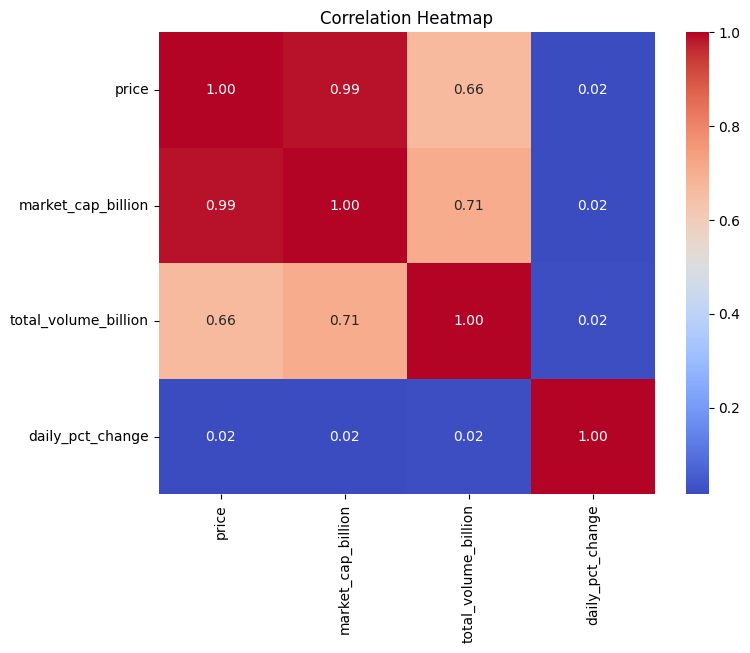

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["price", "market_cap_billion", "total_volume_billion", "daily_pct_change"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [16]:
# Convert date column to datetime format
df["date"] = pd.to_datetime(df["date"])

# Choose the resampling frequency ('W' for Weekly, 'M' for Monthly)
resample_freq = 'W'  # Change to 'M' for monthly data

# Aggregate data per coin
df_resampled = df.groupby("coin").resample(resample_freq, on="date").agg({
    "price": "mean",  # Average price per week/month
    "market_cap_billion": "mean",  # Average market cap per period
    "total_volume_billion": "sum",  # Total traded volume per period
    "daily_pct_change": "mean"  # Average daily percentage change
}).reset_index()

# Display the resampled dataset
df_resampled.head()

,coin,date,price,market_cap_billion,total_volume_billion,daily_pct_change
0,bitcoin,2024-03-03,61070.966591,1199.611769,268.792750,1.799315
1,bitcoin,2024-03-10,66492.191355,1305.349754,404.775938,1.491132
2,bitcoin,2024-03-17,70283.038387,1381.343451,413.362968,-0.632123
3,bitcoin,2024-03-24,65630.965508,1290.311325,365.629223,-0.081189
4,bitcoin,2024-03-31,69585.612822,1366.715475,223.267038,1.185576


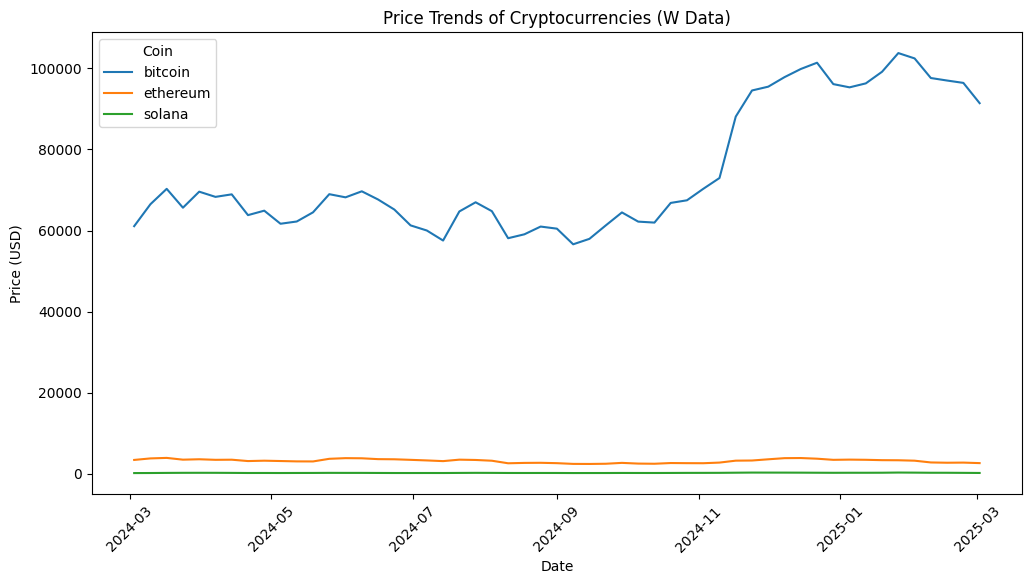

In [17]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_resampled, x="date", y="price", hue="coin")
plt.title(f"Price Trends of Cryptocurrencies ({resample_freq} Data)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(title="Coin")
plt.xticks(rotation=45)
plt.show()

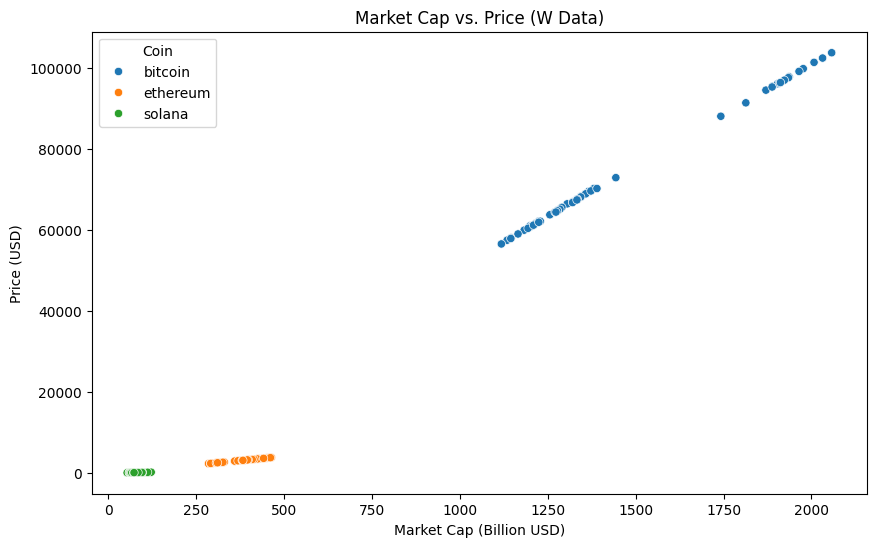

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_resampled, x="market_cap_billion", y="price", hue="coin")
plt.title(f"Market Cap vs. Price ({resample_freq} Data)")
plt.xlabel("Market Cap (Billion USD)")
plt.ylabel("Price (USD)")
plt.legend(title="Coin")
plt.show()

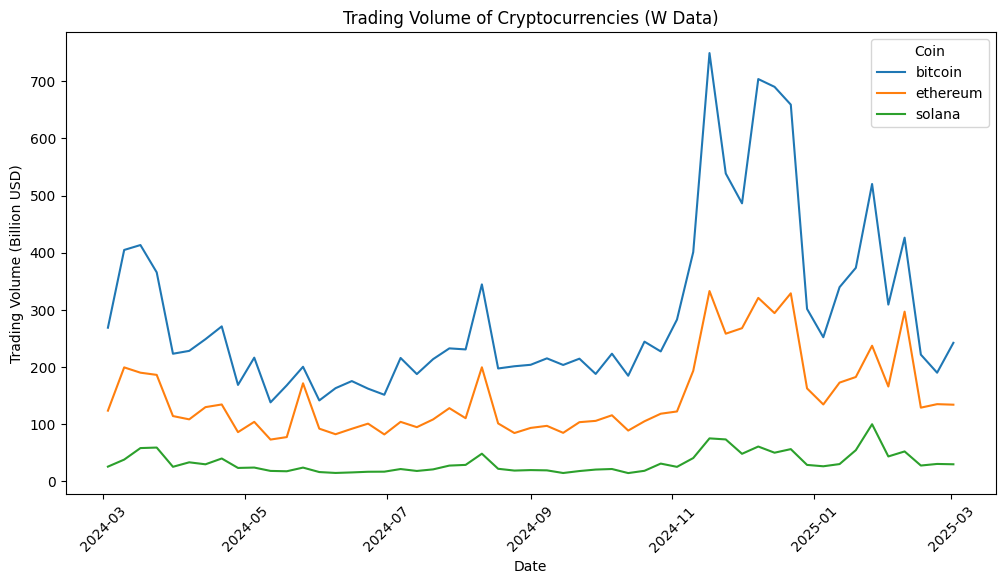

In [19]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_resampled, x="date", y="total_volume_billion", hue="coin")
plt.title(f"Trading Volume of Cryptocurrencies ({resample_freq} Data)")
plt.xlabel("Date")
plt.ylabel("Trading Volume (Billion USD)")
plt.legend(title="Coin")
plt.xticks(rotation=45)
plt.show()

In [20]:
# Save the resampled dataset
df_resampled.to_csv(f"/content/drive/MyDrive/Crypto data/cleaned_historical_crypto_data_{resample_freq}.csv", index=False)
print(f"Data saved successfully as {resample_freq} level data!")

Data saved successfully as W level data!


In [21]:
# Ensure date is in datetime format
df_resampled["date"] = pd.to_datetime(df_resampled["date"])

# Calculate rolling standard deviation for price (7-day window)
df_resampled["volatility"] = df_resampled.groupby("coin")["price"].transform(lambda x: x.rolling(window=7).std())

# Display updated dataset
df_resampled.head()

,coin,date,price,market_cap_billion,total_volume_billion,daily_pct_change,volatility
0,bitcoin,2024-03-03,61070.966591,1199.611769,268.792750,1.799315,NaN
1,bitcoin,2024-03-10,66492.191355,1305.349754,404.775938,1.491132,NaN
2,bitcoin,2024-03-17,70283.038387,1381.343451,413.362968,-0.632123,NaN
3,bitcoin,2024-03-24,65630.965508,1290.311325,365.629223,-0.081189,NaN
4,bitcoin,2024-03-31,69585.612822,1366.715475,223.267038,1.185576,NaN


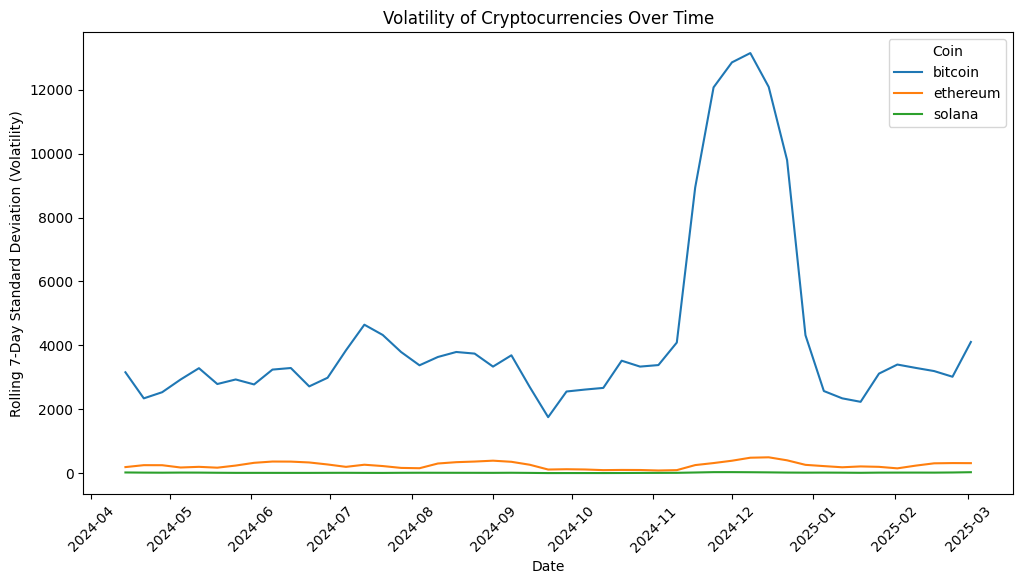

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_resampled, x="date", y="volatility", hue="coin")
plt.title("Volatility of Cryptocurrencies Over Time")
plt.xlabel("Date")
plt.ylabel("Rolling 7-Day Standard Deviation (Volatility)")
plt.legend(title="Coin")
plt.xticks(rotation=45)
plt.show()

      coin       date  ATR
0  bitcoin 2024-03-03  NaN
1  bitcoin 2024-03-10  NaN
2  bitcoin 2024-03-17  NaN
3  bitcoin 2024-03-24  NaN
4  bitcoin 2024-03-31  NaN


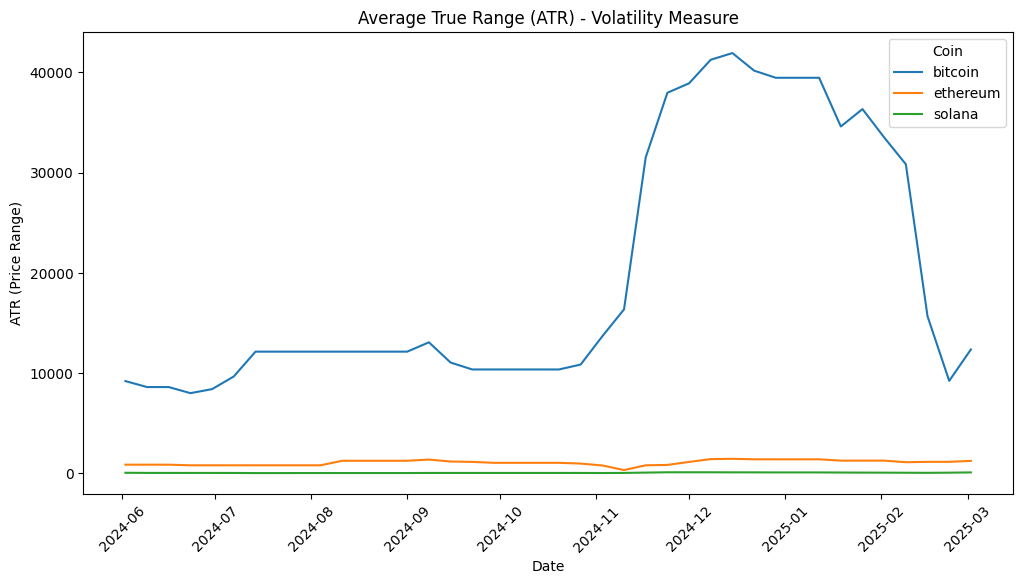

In [26]:
# Calculate Average True Range (ATR) - Volatility Measure
df_resampled["ATR"] = df_resampled.groupby("coin")["price"].transform(lambda x: x.rolling(window=14).apply(lambda y: y.max() - y.min()))

# Print first few rows with ATR
print(df_resampled[["coin", "date", "ATR"]].head())

# Plot ATR for different cryptocurrencies
plt.figure(figsize=(12,6))
sns.lineplot(data=df_resampled, x="date", y="ATR", hue="coin")
plt.title("Average True Range (ATR) - Volatility Measure")
plt.xlabel("Date")
plt.ylabel("ATR (Price Range)")
plt.legend(title="Coin")
plt.xticks(rotation=45)
plt.show()

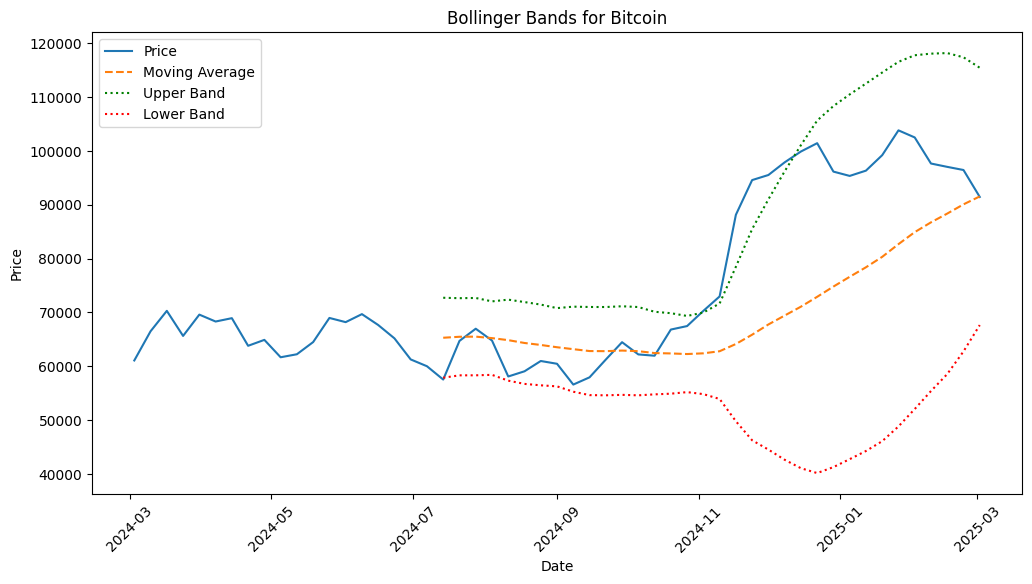

In [25]:
df_resampled["moving_avg"] = df_resampled.groupby("coin")["price"].transform(lambda x: x.rolling(window=20).mean())
df_resampled["std_dev"] = df_resampled.groupby("coin")["price"].transform(lambda x: x.rolling(window=20).std())

df_resampled["upper_band"] = df_resampled["moving_avg"] + (df_resampled["std_dev"] * 2)
df_resampled["lower_band"] = df_resampled["moving_avg"] - (df_resampled["std_dev"] * 2)

# Visualizing Bollinger Bands
plt.figure(figsize=(12,6))
coin = "bitcoin"  # Change to any coin you want to analyze
df_coin = df_resampled[df_resampled["coin"] == coin]

plt.plot(df_coin["date"], df_coin["price"], label="Price")
plt.plot(df_coin["date"], df_coin["moving_avg"], label="Moving Average", linestyle="dashed")
plt.plot(df_coin["date"], df_coin["upper_band"], label="Upper Band", linestyle="dotted", color="green")
plt.plot(df_coin["date"], df_coin["lower_band"], label="Lower Band", linestyle="dotted", color="red")

plt.title(f"Bollinger Bands for {coin.capitalize()}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.show()